# PC/NC classification by CNN

The convolutional neural network (CNN) was invented for image processing.
We can use Conv1D layers for processing string sequences. 
How well does CNN work on human RNA as a binary classifier of protein-coding/non-coding?  




Trying filters at 64.

Assume user downloaded files from GenCode 38 [FTP](http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/)
to a subdirectory called data.

In [1]:
import time 
def show_time():
    t = time.time()
    s = time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))
    print(s)
show_time()

2021-06-03 16:23:22 UTC


In [2]:
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'

In [3]:
PC_SEQUENCES=20000   # how many protein-coding sequences
NC_SEQUENCES=20000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
BASES=1000            # how long is each sequence
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (BASES,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (BASES,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 64   # how many different patterns the model looks for
NEURONS = 16
DROP_RATE = 0.2
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=5  # how many times to train on all the data
SPLITS=5  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=1  # train the model this many times (range 1 to SPLITS)

In [4]:
import sys
import csv

try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='../data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import *
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.
Mounted at /content/drive/


In [5]:
from os import listdir
#from zipfile import ZipFile
import gzip

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import Flatten,MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [6]:
def load_gencode(filename,label):
    DEFLINE='>'
    DELIM='|'
    EMPTY=''
    labels=[]  # usually 1 for protein-coding or 0 for non-coding
    seqs=[]    # usually string of ACGT
    lens=[]    # sequence length
    ids=[]     # GenCode transcript ID, always starts ENST
    one_seq = EMPTY
    one_id = None
    # Use gzip 'r' mode to open file in read-only mode.
    # Use gzip 't' mode to read each line of text as type string.
    with gzip.open (filename,'rt') as infile:
        for line in infile:
            if line[0]==DEFLINE:
                # Save the previous sequence if one exists.
                if not one_seq == EMPTY:
                    labels.append(label)
                    seqs.append(one_seq)
                    lens.append(len(one_seq))
                    ids.append(one_id)
                # Get ready to read the next sequence. 
                # Parse a GenCode defline that is formatted like this:
                # >transcript_ID|gene_ID|other_fields other_info|other_info
                one_id = line[1:].split(DELIM)[0]
                one_seq = EMPTY
            else:
                # Continue loading sequence lines till next defline.
                additional = line.rstrip()
                one_seq = one_seq + additional
        # Don't forget to save the last sequence after end-of-file.
        if not one_seq == EMPTY:
            labels.append(label)
            seqs.append(one_seq)
            lens.append(len(one_seq))
            ids.append(one_id)

    df1=pd.DataFrame(ids,columns=['tid'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

In [7]:
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
pcdf=load_gencode(PC_FULLPATH,1)
print("PC seqs loaded:",len(pcdf))
ncdf=load_gencode(NC_FULLPATH,0)
print("NC seqs loaded:",len(ncdf))

PC seqs loaded: 106143
NC seqs loaded: 48752


In [8]:
def uniform_length(seqs,hardlen,too_big):
    newseqs=[]
    pad='T'*hardlen
    too_small=200 ## by definition of long non-coding RNA
    for seq in seqs:
        size=len(seq)
        if (size>too_small and size<too_big):
            big=seq+pad
            little=big[:hardlen]
            newseqs.append(little)
    return newseqs

In [9]:
from sklearn.model_selection import train_test_split
pc_all = pcdf['sequence']
nc_all = ncdf['sequence']
# The split function also shuffles
pc_train,pc_test=train_test_split(pc_all,test_size=0.10,random_state=1234)
nc_train,nc_test=train_test_split(nc_all,test_size=0.10,random_state=1234)

In [10]:
# Use code from our SimTools library.
UNIFORM_LENGTH=1000
MAXIMUM_LENGTH=2000
pc_seqs=uniform_length(pc_train,UNIFORM_LENGTH,MAXIMUM_LENGTH-500)
print("PC seqs ready:",len(pc_seqs))
nc_seqs=uniform_length(nc_train,UNIFORM_LENGTH,MAXIMUM_LENGTH+2000)
print("NC seqs ready:",len(nc_seqs))
X,y = prepare_inputs_len_x_alphabet(pc_seqs,nc_seqs,ALPHABET) # shuffles
print("Data ready")

PC seqs ready: 44652
NC seqs ready: 42211
Data ready


In [11]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Flatten())
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (1000, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1000, 64)          832       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 64)          12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 64)           12352     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 64)           12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
flatten (Flatten)       

In [12]:
from keras.callbacks import ModelCheckpoint

def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


2021-06-03 16:24:24 UTC
MODEL
make_DNN
input shape: (1000, 4)
FIT
Epoch 1/5
2172/2172 [==============================] - 60s 8ms/step - loss: 0.6344 - accuracy: 0.6373 - val_loss: 0.6893 - val_accuracy: 0.5191
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/5
2172/2172 [==============================] - 16s 7ms/step - loss: 0.6630 - accuracy: 0.6046 - val_loss: 0.6671 - val_accuracy: 0.6124
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 3/5
2172/2172 [==============================] - 17s 8ms/step - loss: 0.6736 - accuracy: 0.5858 - val_loss: 0.6949 - val_accuracy: 0.4792
Epoch 4/5
2172/2172 [==============================] - 17s 8ms/step - loss: 0.6925 - accuracy: 0.5161 - val_loss: 0.6925 - val_accuracy: 0.5184
Epoch 5/5
2172/2172 [==============================] - 16s 7ms/step - loss: 0.6932 - accuracy: 0.5068 - val_loss: 0.6926 - val_accuracy: 0.5197
Fold 1, 5 epochs, 128 sec


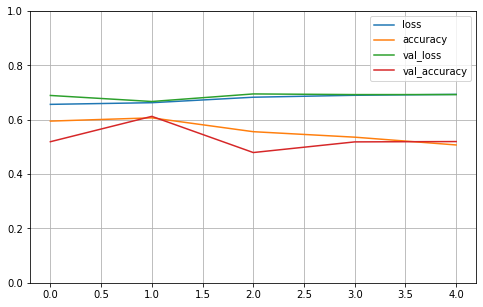

2021-06-03 16:26:33 UTC


In [13]:
show_time()
do_cross_validation(X,y)
show_time()